# Square root of a convolution kernel

$$Tu := \psi \ast u$$

$$T^{1/2} u = z \ast u$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import fft
from tqdm.auto import tqdm

from nalger_helper_functions import *

## Options

In [2]:
grid_spacing_factor = 0.25 # smaller = denser grid
psi_sign_factor = 1. # -1. for negative operator / imaginary square root kernel
symmetric_kernel = False # True for symmetric kernel psi

# kernel_type = 'gaussian'
# kernel_type = 'positive_blob' # interesting
kernel_type = 'gabor'
# kernel_type = 'gabor_higher_frequency'

positive_real_branch_cut = np.pi # sqrt branch cut for frequencies with positive real part
negative_real_branch_cut = 0. # # sqrt branch cut for frequencies with negative real part
pre_expansion = 0 # k -> extend box by zero k widths in each direction before taking fft
post_contraction = 0 # k -> restrict box by k widths in each direction before taking inverse fft

build_dense = False # True for building dense matrix at the end

## Set up grid and boxes

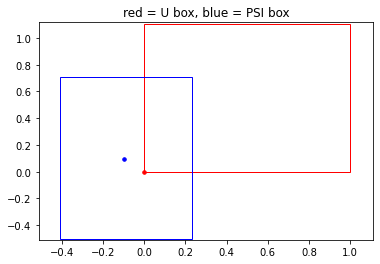

In [3]:
hh = np.array([0.025, 0.03]) * grid_spacing_factor

U_centerpoint = np.zeros(2)
min_U, max_U, U_shape = conforming_box(np.array([0., 0.]), np.array([1., 1.1]), U_centerpoint, hh)

PSI_centerpoint = np.round(np.array([-0.1, 0.1]) / hh) * hh
min_PSI, max_PSI, PSI_shape = conforming_box(np.array([-0.4, -0.5]), np.array([0.23, 0.7]), PSI_centerpoint, hh)

min_plot, max_plot, plot_shape = conforming_box(np.min([min_U, min_PSI])-hh, np.max([max_U, max_PSI])+hh, 
                                                np.zeros(2), hh)

r1 = plot_rectangle(min_U, max_U, edgecolor='r')
plt.plot(U_centerpoint[0], U_centerpoint[1], '.r', markersize=7)

r2 = plot_rectangle(min_PSI, max_PSI, edgecolor='b')
plt.plot(PSI_centerpoint[0], PSI_centerpoint[1], '.b', markersize=7)

plt.xlim(min_plot[0], max_plot[0])
plt.ylim(min_plot[1], max_plot[1])

plt.title('red = U box, blue = PSI box')

plt.show()

## Create convolution kernel $\psi$

In [4]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

PSI(np.zeros(2))= [22.71152846]
boxintegrate(PSI)= 0.013096232262684568
nonsymmetry= 1.5273683578441495


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:205: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array)


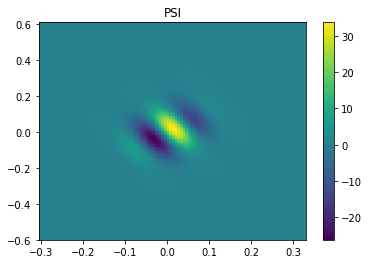

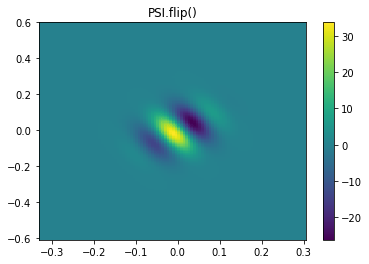

In [5]:
mu = PSI_centerpoint
Sigma = np.array([[0.004, 0.0015], 
                  [0.0015, 0.011]])*0.7

PSI = BoxFunction(min_PSI, max_PSI, np.zeros(PSI_shape))
X, Y = PSI.meshgrid

G = make_2D_grid_gaussian(mu, Sigma, X, Y)

if kernel_type == 'positive_blob':
    PSI.array = G * np.sin(40*X + 16*Y)**2 * psi_sign_factor # interesting
elif kernel_type == 'gabor':
    PSI.array = -G * np.sin(40*X + 16*Y) * psi_sign_factor
elif kernel_type == 'gabor_higher_frequency':
    PSI.array = G * np.sin(80*X + 32*Y) * psi_sign_factor
else: # kernel_type == 'gaussian'
    PSI.array = G * psi_sign_factor

PSI = PSI.translate(-PSI_centerpoint)

# PSI.array[tuple(PSI.zeropoint_index)] = 4.468387651296901
print('PSI(np.zeros(2))=', PSI(np.zeros(2)))

PSI_sum = np.sum(PSI.array)
print('boxintegrate(PSI)=', boxintegrate(PSI))


if symmetric_kernel:
    PSI = (PSI + PSI.flip()) / 2. # make symmetric

nonsymmetry = boxnorm(PSI - PSI.flip()) / boxnorm(PSI)
print('nonsymmetry=', nonsymmetry)

PSI.plot(title='PSI')
PSI.flip().plot(title='PSI.flip()')

## Compute convolution kernel, $z$, for square root operator

Z_imag_fraction= 8.544692179824827e-05


/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:190: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array.real)
/home/nick/repos/nalger_helper_functions/nalger_helper_functions/box_function.py:196: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, me.array.imag)


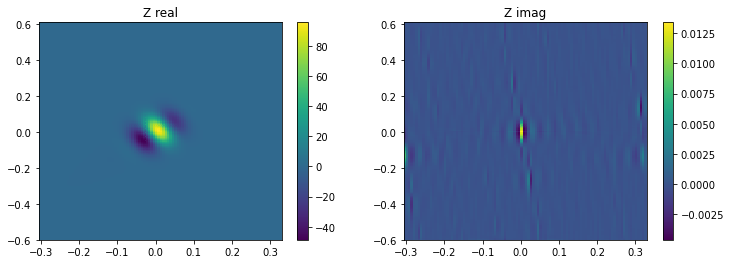

In [6]:
Z = convolution_square_root(PSI, 
                            positive_real_branch_cut=positive_real_branch_cut, 
                            negative_real_branch_cut=negative_real_branch_cut,
                            pre_expansion=pre_expansion,
                            post_contraction=post_contraction)

Z_imag_fraction = boxnorm(Z.imag) / boxnorm(Z)
print('Z_imag_fraction=', Z_imag_fraction)

Z.plot(title='Z')

## Make some functions $u$ and $v$ to test convolutions on

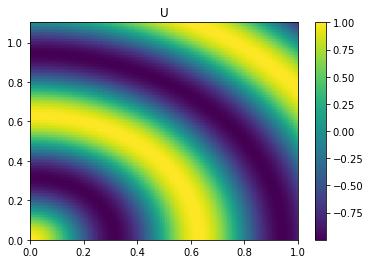

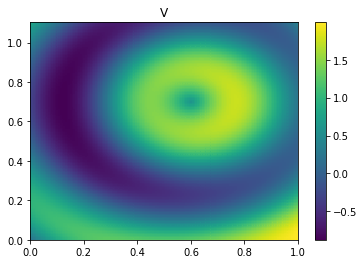

In [7]:
U = BoxFunction(min_U, max_U, np.zeros(U_shape))
XU, YU = U.meshgrid

U.array = np.cos(10*np.sqrt(XU**2 + YU**2))

U = U.translate(-U_centerpoint)

U.plot(title='U')

V_data = np.sin(10*np.sqrt((XU-0.6)**2 + (YU - 0.7)**2)) + XU

V = BoxFunction(min_U, max_U, V_data).translate(-U_centerpoint)

V.plot(title='V')

## Check adjoint correctness

In [8]:
ip1 = boxinner(boxconv(Z, U), V)
ip2 = boxinner(U, boxconv(Z.flip().conj(), V))
err_adj = np.abs((ip1 - ip2) / ip1)
print('err_adj=', err_adj)

err_adj= 6.385213338839209e-17


## Compute convolution with $\psi$ directly

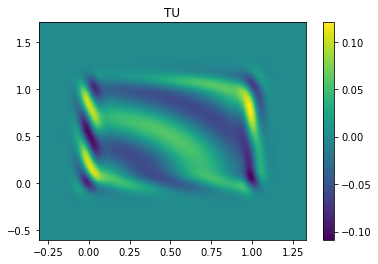

In [9]:
TU = boxconv(PSI, U)

TU.plot(title='TU')

## Compute convolution by applying square root operator twice

In [10]:
sqrtTU = boxconv(Z, U)
TU2 = boxconv(Z, sqrtTU)

ERR = TU2 - TU

err_sqrt = boxnorm(ERR) / boxnorm(TU)
print('err_sqrt=', err_sqrt)

err_sqrt= 0.007901767928012823


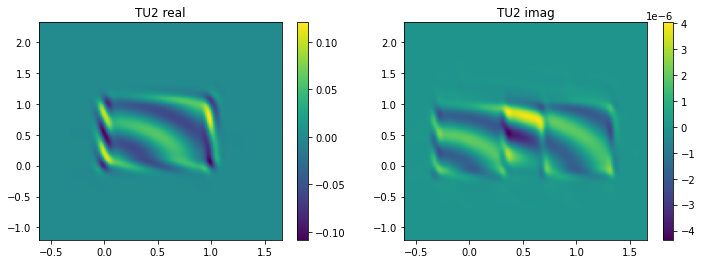

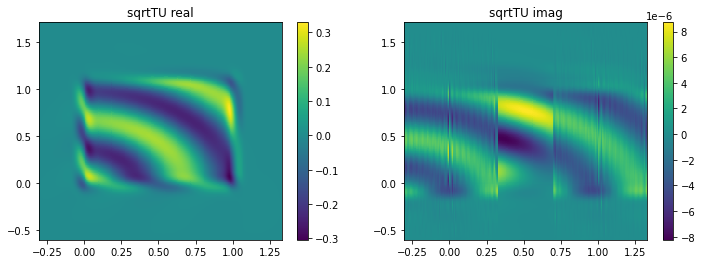

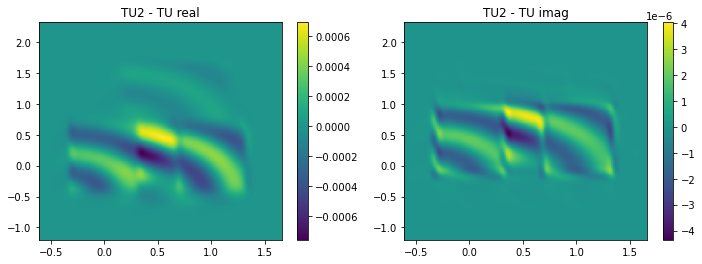

In [11]:
TU2.plot('TU2')
sqrtTU.plot('sqrtTU')
ERR.plot(title='TU2 - TU')

## OPTIONAL: build dense matrices for all the convolution operators

In [12]:
if build_dense:
    def convolve_with_Z(x):
        X = BoxFunction(U.min, U.max, x.reshape(U.shape))
        Y = boxconv(Z, X).restrict_to_new_box(U.min, U.max)
        return Y.array.reshape(-1)

    n = np.prod(U.shape)
    sqrtT = np.zeros((n,n), dtype='complex')
    for k in tqdm(range(n)):
        ek = np.zeros(n, dtype='complex')
        ek[k] = 1.
        sqrtT[:,k] = convolve_with_Z(ek)

    Z_star = Z.flip().conj()
    def convolve_with_Z_star(x):
        X = BoxFunction(U.min, U.max, x.reshape(U.shape))
        Y = boxconv(Z_star, X).restrict_to_new_box(U.min, U.max)
        return Y.array.reshape(-1)

    sqrtT_star = np.zeros((n,n), dtype='complex')
    for k in tqdm(range(n)):
        ek = np.zeros(n, dtype='complex')
        ek[k] = 1.
        sqrtT_star[:,k] = convolve_with_Z_star(ek)

    def convolve_with_PSI(x):
        X = BoxFunction(U.min, U.max, x.reshape(U.shape))
        Y = boxconv(PSI, X).restrict_to_new_box(U.min, U.max)
        return Y.array.reshape(-1)

    T = np.zeros((n,n), dtype='complex')
    for k in tqdm(range(n)):
        ek = np.zeros(n, dtype='complex')
        ek[k] = 1.
        T[:,k] = convolve_with_PSI(ek)

    np.linalg.norm(sqrtT.T.conj() - sqrtT_star) / np.linalg.norm(sqrtT)

    sqrtTsqrtT = sqrtT @ sqrtT # np.dot(sqrtT, sqrtT)

    err_sqrtTsqrtT_minus_T = np.linalg.norm(sqrtTsqrtT - T) / np.linalg.norm(T)
    print('err_sqrtTsqrtT_minus_T=', err_sqrtTsqrtT_minus_T)

    sqrtT_star_sqrtT = sqrtT_star @ sqrtT

    err_sqrtT_star_sqrtT_minus_T = np.linalg.norm(sqrtT_star_sqrtT - T) / np.linalg.norm(T)
    err_sqrtT_star_sqrtT_plus_T = np.linalg.norm(sqrtT_star_sqrtT + T) / np.linalg.norm(T)
    err_sqrtT_star_sqrtT_minus_Tsym = np.linalg.norm(sqrtT_star_sqrtT - (T+T.T)/2.) / np.linalg.norm(T)
    err_sqrtT_star_sqrtT_plus_Tsym = np.linalg.norm(sqrtT_star_sqrtT + (T+T.T)/2.) / np.linalg.norm(T)

    print('err_sqrtT_star_sqrtT_minus_T=', err_sqrtT_star_sqrtT_minus_T, 
          ', err_sqrtT_star_sqrtT_plus_T=', err_sqrtT_star_sqrtT_plus_T)
    print('err_sqrtT_star_sqrtT_minus_Tsym=', err_sqrtT_star_sqrtT_minus_Tsym, 
          ', err_sqrtT_star_sqrtT_plus_Tsym=', err_sqrtT_star_sqrtT_plus_Tsym)